# General Kalman Filter 

In [6]:
import numpy as np
def PredictedAndPosterior( Observations, priorThetaMean, priorThetaVariance,transitionMatrix, transitionNoiseVariance, observationMatrix, observationNoiseVariance):
    ObservationPrediction = []
    ThetasPredictedMean = []
    ThetasPredictedVar = []
    ThetasPosteriorMean = []
    ThetasPosteriorVar = []
    SmoothedObservations = []
    ThetaMean= priorThetaMean
    ThetaVar = priorThetaVariance
    
    for i in range(0,len(Observations)):

        PredictionThetaMean = transitionMatrix@ThetaMean
 
        PredictionThetaVariance = transitionMatrix @ (ThetaVar @ transitionMatrix.T) + transitionNoiseVariance
        
        ThetasPredictedMean.append(PredictionThetaMean)
        ThetasPredictedVar.append(PredictionThetaVariance)
        ObservationPrediction.append( observationMatrix @ PredictionThetaMean )
     
        CovarianceOfInnovation =  observationMatrix @ ( PredictionThetaVariance @ observationMatrix.T)+ observationNoiseVariance
        OptimalKalmanGain = PredictionThetaVariance @ ( observationMatrix.T @ np.linalg.inv(CovarianceOfInnovation) )
        
        Innovation = Observations[i] - np.matmul( observationMatrix,PredictionThetaMean )
       
        ThetaMean = PredictionThetaMean + np.matmul(OptimalKalmanGain,Innovation)
        
        ThetaVar = np.matmul((np.identity(transitionMatrix.shape[0])-np.matmul( OptimalKalmanGain,observationMatrix)) , PredictionThetaVariance)
        
        SmoothedObservations.append( observationMatrix @ ThetaMean )
        ThetasPosteriorMean.append(ThetaMean)
        ThetasPosteriorVar.append(ThetaVar)
    
    return ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations

In [2]:
def GenerateSample(trueTheta,transitionMatrix, transitionNoiseVariance, observationMatrix, observationNoiseVariance, number):
    
   
    Observations = []
    TrueThetas = []
    ThetaK = trueTheta
    MeanO = [0] * observationNoiseVariance.shape[0]
    MeanT= [0] * transitionNoiseVariance.shape[0]
    
    for i in range(0,number):
       
        ThetaK = (transitionMatrix@ ThetaK) + np.transpose( np.random.default_rng().multivariate_normal(MeanT,transitionNoiseVariance,1) )
        
        ObservationK = (observationMatrix@ ThetaK) + np.transpose( np.random.default_rng().multivariate_normal(MeanO,observationNoiseVariance,1) )
 
        Observations.append(ObservationK)
        TrueThetas.append(ThetaK)
    
    return TrueThetas, Observations

In [9]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from ipywidgets import interactive 
output_notebook()


def GeneralKalmanFilter( trueTheta, transitionMatrix, transitionNoiseVariance, observationMatrix, observationNoiseVariance, priorThetaMean, priorThetaVariance,number):

    #simulat some data
    TrueThetas, Observations = GenerateSample(trueTheta,transitionMatrix, transitionNoiseVariance, observationMatrix, observationNoiseVariance, number)
    
    #Calculate predicted theta for each time step as well as the posterior
    ObservationPrediction ,ThetasPredictedMean ,ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations = PredictedAndPosterior( Observations, priorThetaMean, priorThetaVariance,transitionMatrix, transitionNoiseVariance, observationMatrix, observationNoiseVariance)
    return TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations
    
    
    

Loading BokehJS ...

# Useful Functions

In [20]:
def LeadLag(path,lagging =1):
    if lagging == 0:
        return path
    
    path = np.repeat(path, lagging+1,axis=0)
    lead = np.copy(path)
    lead = lead[lagging:]
    lag = np.copy(path)
    lag = path[:-lagging]

    
    path = np.concatenate((lead,lag),axis=1)
    return(path)

# Testing Kalman Filter


In [7]:
TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations=GeneralKalmanFilter(
    #True Theta
    np.array([[2]]),
    #Transition Matrix
   np.array([[1.1]]),
    #TransitionNoiseVariance
    np.array([[1]]),
    #Observation Matrix
    np.array([[2]]),
    #ObservationNoiseVariance
    np.array([[1]]),
    #priorTheta Mean
    np.array([[3]]),
    #priorTheta Variance
    np.array([[2]]),
    #number of observations
    33              
)

In [12]:
# Plot predictions against observations
yObs = np.array(Observations)
a,b,c = yObs.shape
yObs= yObs.reshape((a,b*c))

yPred = np.array(ObservationPrediction)
a,b,c = yPred.shape
yPred= yPred.reshape((a,b*c))

x = np.linspace( 0 ,len(yPred),  len(yPred)) 
p = figure(title="Gaussian DLM", x_axis_label="TimeStep", y_axis_label="Position (ie yk)")
p.circle(x, yPred[:,0], legend_label="Positions Predicted", color="green", size=8)
p.circle(x, yObs[:,0], legend_label="Observed Positions", color="red", size=8)
show(p) 

# Models

## 2D Constant velocity model

In [22]:
observation_variance = 1.2
transition_variance = 0.4


TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar, SmoothedObservations=GeneralKalmanFilter(
    #True Theta
    np.array([[1,1,2,3]]).T,
    #Transition Matrix
    np.array([[1, 0, 1, 0],[0, 1, 0, 1],[0, 0, 1, 0],[0, 0, 0, 1]]),
    #TransitionNoiseVariance
    transition_variance * np.eye(4),
    #Observation Matrix
    np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]]),
    #ObservationNoiseVariance
    observation_variance * np.eye(2),   
    #priorTheta Mean
    np.array([[1,1,3,4]]).T,
    #priorTheta Variance
    3* np.eye(4),
    #number of observations
    33              
)


In [25]:
yObs = np.array(Observations)
a,b,c = yObs.shape
yObs= yObs.reshape((a,b*c))

yPred = np.array(SmoothedObservations)
a,b,c = yPred.shape
yPred= yPred.reshape((a,b*c))
p = figure(title="Gaussian DLM", x_axis_label="x", y_axis_label="y")
p.line(yPred[:,1],yPred[:,0], legend_label="Positions Smoothed", color="green")
p.line(yObs[:,1],yObs[:,0], legend_label="Observed Positions", color="red" )
show(p) 

## 3D contant velocity model


In [26]:
xMoveVar=1
yMoveVar=1
zMoveVar=0
T=1
observationNoise=1
TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations=GeneralKalmanFilter(
                #True Theta
                #[x,xVel,y,yVel,z]
                np.array( [[1,1,3,3,0]]).T,
                #Transition Matrix
                np.array([
                            [ 1, T, 0, 0, 0],
                            [ 0, 1, 0, 0, 0],
                            [ 0, 0, 1, T, 0],
                            [ 0, 0, 0, 1, 0],
                            [ 0, 0, 0, 0, 1]
                        ]),
                #TransitionNoiseVariance
                np.array([
                            [ xMoveVar*( (T**4)/4 ), xMoveVar*( (T**3)/2 ), 0, 0,0],
                            [ xMoveVar*( (T**3)/2), xMoveVar*( T**2 ), 0, 0, 0],
                            [ 0, 0, yMoveVar*( (T**4)/4 ), yMoveVar*( (T**3)/2 ), 0],
                            [ 0, 0,yMoveVar*( (T**3)/2 ), yMoveVar*( T**2 ), 0],
                            [ 0, 0, 0, 0, zMoveVar]
                        ]),
                #Observation Matrix
                np.array([
                            [ 1, 0, 0, 0, 0],
                            [ 0, 0, 1, 0, 0],
                            [ 0, 0, 0, 0, 1]
                        ]),
                #ObservationNoiseVariance
                #observationNoise * np.eye(3),
                np.array([
                            [ 1, 0, 0],
                            [ 0, 1, 0],
                            [ 0, 0, 0.01]
                        ]),   
                #priorTheta Mean
                np.array([ [1,3,3,5,0]]).T,
                #priorTheta Variance
                2* np.eye(5),
                #number of observations
                33              
            ) 

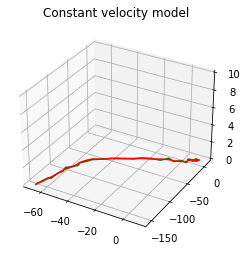

In [28]:
Observations = np.array(Observations)
Observations = Observations.reshape(Observations.shape[0],-1)

SmoothedObservations = np.array(SmoothedObservations)
SmoothedObservations = SmoothedObservations.reshape(SmoothedObservations.shape[0],-1)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis

 
# plotting
ax.plot(Observations[:,1],Observations[:,0],Observations[:,2], 'green')
ax.plot(ObservationPrediction[:,1],ObservationPrediction[:,0],ObservationPrediction[:,2], 'red')
ax.axes.set_zlim3d(bottom=0, top=10) 

ax.set_title('Constant velocity model')
plt.show()

## Constant Turn rate model

In [32]:
import math
T=1
w= 0.3
TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations=GeneralKalmanFilter(
                #True Theta
                #[x,xVel,y,yVel]
                np.array( [[0,1,0,1]]).T,
                #Transition Matrix
                np.array([
                            [ 1, math.sin(w*T)/w, 0, (math.cos(w*T)-1)/w],
                            [ 0, math.cos(w*T), 0, -math.sin(w*T)],
                            [ 0, (1-math.cos(w*T))/w, 1, math.sin(w*T)/w],
                            [ 0, math.sin(w*T), 0, math.cos(w*T)]
                        ]),
                #TransitionNoiseVariance
                np.array([
                            [ 
                                (2*(w*T - math.sin(w*T)))/(w**3), 
                                (1 - math.cos(w*T))/(w**2), 
                                0, 
                                (w*T - math.sin(w*T))/(w**2)
                            ],
                            [ 
                                (1 - math.cos(w*T))/(w**2), 
                                T, 
                                (math.sin(w*T) - w*T)/(w**2), 
                                0
                            ],
                            [ 
                                0, 
                                ((math.sin(w*T) - w*T)/(w**2)),
                                ((2*(w*T - math.sin(w*T)))/(w**3)),
                                ( (1 - math.cos(w*T))/(w**2))
                            ],
                            [ 
                                (w*T - math.sin(w*T))/(w**2), 
                                0,
                                ( (1 - math.cos(w*T))/(w**2)), 
                                T
                            ],
                        ]),
                #Observation Matrix
                np.array([
                            [ 1, 0, 0, 0],
                            [ 0, 0, 1, 0]
                        ]),
                #ObservationNoiseVariance
                #observationNoise * np.eye(3),
                np.array([
                            [ 3, 0],
                            [ 0, 3]
                        ]),   
                #priorTheta Mean
                np.array([ [0,2,0,3]]).T,
                #priorTheta Variance
                1* np.eye(4),
                #number of observations
                33              
            ) 

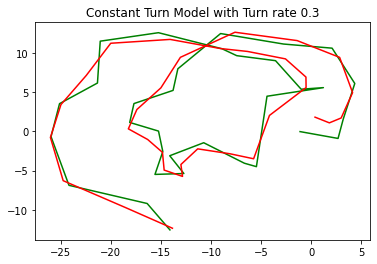

In [34]:
Observations = np.array(Observations)
Observations = Observations.reshape(Observations.shape[0],-1)

SmoothedObservations = np.array(SmoothedObservations)
SmoothedObservations = SmoothedObservations.reshape(SmoothedObservations.shape[0],-1)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes()
 
# defining all 3 axis

 
# plotting
ax.plot(Observations[:,0],Observations[:,1], 'green')
ax.plot(SmoothedObservations[:,0],SmoothedObservations[:,1], 'red')


ax.set_title('Constant Turn Model with Turn rate 0.3')
plt.show()

# Predicting rate of velocity Change

## Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
import iisignature 
import numpy as np
import math
import iisignature 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import random
def Train3D(xMoveVar=1, yMoveVar=1, zMoveVar=0.01, T=1, lag= 0, SignatureLevel=0, observationNoise=1,SignatureLog= False,pathType='Observations',testSize=0.2):
    labels =[]
    Data = []
    for param in [1,0.9, 1.1]:
        for k in range(0,100):
            x = random.randint(0,22)
            y= random.randint(0,22)
            
            TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations=GeneralKalmanFilter(
                #True Theta
                #[x,xVel,y,yVel,z]
                np.array( [[x,1,y,3,0]]).T,
                #Transition Matrix
                np.array([
                            [ 1, T, 0, 0, 0],
                            [ 0, param, 0, 0, 0],
                            [ 0, 0, 1, T, 0],
                            [ 0, 0, 0, param, 0],
                            [ 0, 0, 0, 0, 1]
                        ]),
                #TransitionNoiseVariance
                np.array([
                            [ xMoveVar*( (T**4)/4 ), xMoveVar*( (T**3)/2 ), 0, 0,0],
                            [ xMoveVar*( (T**3)/2), xMoveVar*( T**2 ), 0, 0, 0],
                            [ 0, 0, yMoveVar*( (T**4)/4 ), yMoveVar*( (T**3)/2 ), 0],
                            [ 0, 0,yMoveVar*( (T**3)/2 ), yMoveVar*( T**2 ), 0],
                            [ 0, 0, 0, 0, zMoveVar]
                        ]),
                #Observation Matrix
                np.array([
                            [ 1, 0, 0, 0, 0],
                            [ 0, 0, 1, 0, 0],
                            [ 0, 0, 0, 0, 1]
                        ]),
                #ObservationNoiseVariance
                observationNoise * np.eye(3),   
                #priorTheta Mean
                np.array([ [x,3,y,5,0]]).T,
                #priorTheta Variance
                2* np.eye(5),
                #number of observations
                33              
            )                  
            if( pathType == 'Observations'):
                path = Observations
                d=3
            elif( pathType == 'ObservationPrediction'):
                path = ObservationPrediction
                d=3
            elif( pathType == 'SmoothedObservations'):
                path = SmoothedObservations
                d=3
            elif( pathType == 'ThetasPosteriorMean'):
                path = ThetasPosteriorMean
                d=5
            
            path = np.array(path)
            a,b,c = path.shape
            path = path.reshape(a,b*c)
            if(SignatureLevel>0):
               
                path = LeadLag(path,lagging=lag)
               
                if( SignatureLog ):
                    if(lag>0):
                        d= d*2
                    s = iisignature.prepare(d,SignatureLevel)
                    signature = iisignature.logsig(path,s)
                else:
                    signature = iisignature.sig(path ,SignatureLevel)
                
                Data.append(signature)

            else:
               
                path = LeadLag(path,lagging=lag)
               
                Data.append(path)
            
         
            labels.append(int(round((param-0.9)/0.1)))
    
   
    Data= np.array(Data)
    
    Data = Data.reshape(Data.shape[0],-1)
    accuracy =[]
    for i in range(1,21):
        X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=testSize)
        clf = RandomForestClassifier(n_estimators=30, random_state=42)   # You can choose a different classifier
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy.append( accuracy_score(y_test, y_pred))
        
    #report = classification_report(y_test, y_pred)
    return np.mean(accuracy)

### Comparing Performance

In [42]:
print("Lag 0 + Observation")
print(Train3D(lag=0))

print("Lag 1 + Observation")
print(Train3D(lag=1))

print("Lag 0 + SmoothedObservations")
print(Train3D(lag=0,pathType='SmoothedObservations'))

print("Lag 1 + SmoothedObservations")
print(Train3D(lag=1,pathType='SmoothedObservations'))

Lag 0 + Observation
0.7525
Lag 1 + Observation
0.8066666666666666
Lag 0 + SmoothedObservations
0.7825
Lag 1 + SmoothedObservations
0.8016666666666667


In [43]:
print("Lag 0 + LogSig(Observations, 3)")
print(Train3D(SignatureLog=True,SignatureLevel=3,lag=0))
print("Lag 1 + LogSig(Observations, 3)")
print(Train3D(SignatureLog=True,SignatureLevel=3,lag=1))
print("Lag 0 + LogSig(Smoothed Observations, 3)")
print(Train3D(SignatureLog=True,SignatureLevel=3,lag=0,pathType='SmoothedObservations'))


print("Lag 1 + LogSig(Smoothed Observations, 3)")
print(Train3D(SignatureLog=True,SignatureLevel=3,lag=1,pathType='SmoothedObservations'))

Lag 0 + LogSig(Observations, 3)
0.7625
Lag 1 + LogSig(Observations, 3)
0.8133333333333332
Lag 0 + LogSig(Smoothed Observations, 3)
0.8008333333333335
Lag 1 + LogSig(Smoothed Observations, 3)
0.7674999999999998


In [44]:
print("Lag 0 + Sig(Observations, 3)")
print(Train3D(SignatureLog=False,SignatureLevel=3,lag=0))
print("Lag 1 + Sig(Observations, 3)")
print(Train3D(SignatureLog=False,SignatureLevel=3,lag=1))
print("Lag 0 + Sig(Smoothed Observations, 3)")
print(Train3D(SignatureLog=False,SignatureLevel=3,lag=0,pathType='SmoothedObservations'))

print("Lag 1 + Sig(Smoothed Observations, 3)")
print(Train3D(SignatureLog=False,SignatureLevel=3,lag=1,pathType='SmoothedObservations'))

Lag 0 + Sig(Observations, 3)
0.8149999999999998
Lag 1 + Sig(Observations, 3)
0.7833333333333332
Lag 0 + Sig(Smoothed Observations, 3)
0.8291666666666668
Lag 1 + Sig(Smoothed Observations, 3)
0.8433333333333334


## Neural Network

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.layers import Flatten, Dense


import iisignature 
import numpy as np
import math

def Train3DNN(xMoveVar=1, yMoveVar=1, zMoveVar=0.01, T=1, lag= 0, SignatureLevel=0, observationNoise=1,SignatureLog= False,pathType='Observations',testSize=0.2):
    labels =[]
    Data = []
    for param in [1,0.9, 1.1]:
        for k in range(0,100):
            x = random.randint(0,22)
            y= random.randint(0,22)
            
            TrueThetas, Observations, ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations=GeneralKalmanFilter(
                #True Theta
                #[x,xVel,y,yVel,z]
                np.array( [[x,1,y,3,0]]).T,
                #Transition Matrix
                np.array([
                            [ 1, T, 0, 0, 0],
                            [ 0, param, 0, 0, 0],
                            [ 0, 0, 1, T, 0],
                            [ 0, 0, 0, param, 0],
                            [ 0, 0, 0, 0, 1]
                        ]),
                #TransitionNoiseVariance
                np.array([
                            [ xMoveVar*( (T**4)/4 ), xMoveVar*( (T**3)/2 ), 0, 0,0],
                            [ xMoveVar*( (T**3)/2), xMoveVar*( T**2 ), 0, 0, 0],
                            [ 0, 0, yMoveVar*( (T**4)/4 ), yMoveVar*( (T**3)/2 ), 0],
                            [ 0, 0,yMoveVar*( (T**3)/2 ), yMoveVar*( T**2 ), 0],
                            [ 0, 0, 0, 0, zMoveVar]
                        ]),
                #Observation Matrix
                np.array([
                            [ 1, 0, 0, 0, 0],
                            [ 0, 0, 1, 0, 0],
                            [ 0, 0, 0, 0, 1]
                        ]),
                #ObservationNoiseVariance
                observationNoise * np.eye(3),   
                #priorTheta Mean
                np.array([ [x,3,y,5,0]]).T,
                #priorTheta Variance
                2* np.eye(5),
                #number of observations
                33              
            )                  
            if( pathType == 'Observations'):
                path = Observations
                d=3
            elif( pathType == 'ObservationPrediction'):
                path = ObservationPrediction
                d=3
            elif (pathType == 'SmoothedObservations'):
                path = SmoothedObservations
                d=3
            elif( pathType == 'ThetasPosteriorMean'):
                path = ThetasPosteriorMean
                d=5
        
            
            path = np.array(path)
            a,b,c = path.shape
            path = path.reshape(a,b*c)
            if(SignatureLevel>0):
               
                path = LeadLag(path,lagging=lag)
               
                if( SignatureLog ):
                    if(lag>0):
                        d= d*2
                    s = iisignature.prepare(d,SignatureLevel)
                    signature = iisignature.logsig(path,s)
                else:
                    signature = iisignature.sig(path ,SignatureLevel)
                
                Data.append(signature)

            else:
               
                path = LeadLag(path,lagging=lag)
               
                Data.append(path)
            
         
            labels.append(int(round((param-0.9)/0.1)))
    
   
    data= np.array(Data)
    if(len(data.shape)==2):
        data = data.reshape(data.shape[0],data.shape[1],1)
    labels = np.array(labels)
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    accuracies =[]
    for i in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
        model = Sequential()
        if(SignatureLevel>0):
            model.add(Flatten(input_shape=(data.shape[1], 1)))
            model.add(Dense(64, activation='relu'))
        else:
            model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(num_classes, activation='softmax'))  
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),verbose=0)

        loss, accuracy = model.evaluate(X_test, y_test,verbose=0)
        accuracies.append(accuracy)
    #report = classification_report(y_test, y_pred)
    return np.mean(accuracies)

2023-11-23 13:13:57.248926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
print("Lag 0 + Observation")
print(Train3DNN(lag=0))

print("Lag 1 + Observation")
print(Train3DNN(lag=1))

print("Lag 0 + SmoothedObservations")
print(Train3DNN(lag=0,pathType='SmoothedObservations'))

print("Lag 1 + SmoothedObservations")
print(Train3DNN(lag=1,pathType='SmoothedObservations'))

Lag 0 + Observation


2023-11-23 13:14:08.169883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.5033333331346512
Lag 1 + Observation
0.4850000023841858
Lag 0 + SmoothedObservations
0.4766666620969772
Lag 1 + SmoothedObservations
0.45833333432674406


In [47]:
print("Lag 0 + Sig(Observations, 3)")
print(Train3DNN(SignatureLog=False,SignatureLevel=3,lag=0))
print("Lag 1 + Sig(Observations, 3)")
print(Train3DNN(SignatureLog=False,SignatureLevel=3,lag=1))
print("Lag 0 + Sig(Smoothed Observations, 3)")
print(Train3DNN(SignatureLog=False,SignatureLevel=3,lag=0,pathType='SmoothedObservations'))


print("Lag 1 + Sig(Smoothed Observations, 3)")
print(Train3DNN(SignatureLog=False,SignatureLevel=3,lag=1,pathType='SmoothedObservations'))

Lag 0 + Sig(Observations, 3)
0.448333328962326
Lag 1 + Sig(Observations, 3)
0.4416666656732559
Lag 0 + Sig(Smoothed Observations, 3)
0.39999999701976774
Lag 1 + Sig(Smoothed Observations, 3)
0.40833333432674407


In [48]:
print("Lag 0 + LogSig(Observations, 3)")
print(Train3DNN(SignatureLog=True,SignatureLevel=3,lag=0))
print("Lag 1 + LogSig(Observations, 3)")
print(Train3DNN(SignatureLog=True,SignatureLevel=3,lag=1))
print("Lag 0 + LogSig(Smoothed Observations, 3)")
print(Train3DNN(SignatureLog=True,SignatureLevel=3,lag=0,pathType='SmoothedObservations'))


print("Lag 1 + LogSig(Smoothed Observations, 3)")
print(Train3DNN(SignatureLog=True,SignatureLevel=3,lag=1,pathType='SmoothedObservations'))

Lag 0 + LogSig(Observations, 3)
0.37000000178813935
Lag 1 + LogSig(Observations, 3)
0.4983333319425583
Lag 0 + LogSig(Smoothed Observations, 3)
0.3749999970197678
Lag 1 + LogSig(Smoothed Observations, 3)
0.5
